# Text Classification of News Articles

The [article](https://www.analyticsvidhya.com/blog/2021/12/text-classification-of-news-articles/) discusses how to implement a pythonic text classifier for news articles (as the title implies) for the purposes of data analysis. The [dataset](https://www.kaggle.com/datasets/avishi/bbc-news-train-data) used in the article contains data from BBC. The 3 columns are the following: article id, article text, and category.

The first step in the process is importing the libraries. I'll use comments to explain what each library is used for.

In [1]:
# pandas is usually used for storing data in table-esque forms
import pandas as pd
# numpy is used for data manipulation and quick math with large
# amounts of numbers
import numpy as np
# matplotlib is used for graphing
import matplotlib.pyplot as plt
# seaborn is a library that uses matplotlib under the hood
# for making fancier graphs
import seaborn as sns
# re is for regex
import re
# nltk (natural language toolkit) is a platform for programs
# that work with language, has applications in statistical nlp
import nltk
# stopwords are words that get filtered out before/after processing data
from nltk.corpus import stopwords
nltk.download('stopwords')
# the porter stemmer algorithm removes common morphological and
# inflexional endings from words IN ENGLISH. serves as data normalization
from nltk.stem import PorterStemmer
# wordnetlemmatizer groups different inflections of a word for
# the purpose of analysis as a single entity
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# this one was not included in the article but seems necessary for
# lemmatization
nltk.download('omw-1.4')
# function to split sentence into words
from nltk.tokenize import word_tokenize
# function to split document/paragraph into sentences
from nltk.tokenize import sent_tokenize
# uses an unsupervised algorithm to create model for abbreviations,
# collocations, and words that start sentences
nltk.download('punkt')
# platform to create image of most common words or certain feature words
from wordcloud import WordCloud
# convert text to numerical data in the form of a sparse matrix
# essentially counts each unique word
from sklearn.feature_extraction.text import CountVectorizer
# another form of numerical storing of text
# this one calculates the frequency of each word relative to the document
from sklearn.feature_extraction.text import TfidfVectorizer
# split data into training and testing sets
from sklearn.model_selection import train_test_split
# computes subset accuracy in multilabel classification
from sklearn.metrics import accuracy_score
# confusion matrix is a matrix C such that C[i][j] = # observations
# that are known to be in [i] and predicted to be in [j]
# allows us to see whether model is 'confusing' two labels or not
from sklearn.metrics import confusion_matrix
# builds a text report showing main classification metrics
from sklearn.metrics import classification_report
# make_scorer: makes a scorer from a performance metric or loss function
# roc_curve: calculates receiver operating characteristic. roc is the
#            measure of diagnostic ability of binary classifier systems
# roc_auc_score: compute integral of roc_curve
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
# compute cosine similarity between samples in two vectors
from sklearn.metrics.pairwise import cosine_similarity
# in this case, the OvR method will be used for multilabel classification
from sklearn.multiclass import OneVsRestClassifier
# regularized logistic regression
from sklearn.linear_model import LogisticRegression
# SVC: c-support vector classification. only good for smaller samples
#      since time scales ≥ quadratically with # samples
# LinearSVC: linear support vector classification. scales better and
#            has more flexibility in terms of implementation
from sklearn.svm import SVC, LinearSVC
# supervised ml approach where decision tree is used as a predictive model
# to draw conclusions about a set of observations
from sklearn.tree import DecisionTreeClassifier
# ensemble learning method for classification. operates by constructing
# multiple decision trees. output is most commonly chosen label
from sklearn.ensemble import RandomForestClassifier
# implements k nearest neighbors approach. choses most common label in the
# top k most likely choices
from sklearn.neighbors import KNeighborsClassifier
# naive bayes approach: assumes independence among predictors and applies
#                       bayes' theorem with this concept
# GaussianNB: uses a gaussian probability distribution 
# MultinomialNB: uses a multinomial probability distribution
# BernoulliNB: uses a bernoulli probability distribution
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anmolu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/anmolu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/anmolu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/anmolu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Next up, we need to import the dataset. It'll also be helpful to view some information in it.

In [2]:
dataset = pd.read_csv('BBC News Train.csv')
dataset.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Here, we see the shape of the dataset.

In [3]:
dataset.shape

(1490, 3)

Information about the columns will help us in manipulating the data.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


Looking at the categories specifically, it can be seen that there are 5: Sports, Business, Politics, Entertainment, and Tech. We then convert the given news categories to categorical values.

In [5]:
print(dataset['Category'].value_counts())

# conversion to categorical values
target_category = dataset['Category'].unique()
print(f'\n{target_category}')

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

['business' 'tech' 'politics' 'sport' 'entertainment']


Now we add another column with the purpose of adding an Id for the category.

In [6]:
dataset['CategoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


Proof of concept here using a new dataframe:

In [7]:
category = dataset[['Category', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

,Category,CategoryId
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


## Exploratory Data Analysis

Here we'll visualize the data in order to aid us in looking for patterns to analyze. First, we see the amount of articles in each category.

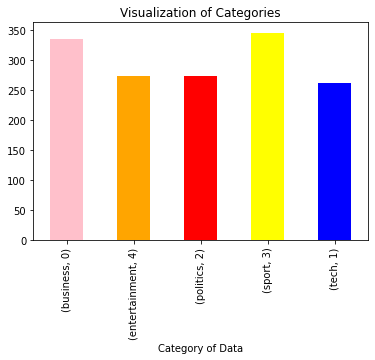

In [8]:
dataset.groupby('Category').CategoryId.value_counts().plot(kind='bar', color=['pink', 'orange', 'red', 'yellow', 'blue'])
plt.xlabel('Category of Data')
plt.title('Visualization of Categories')
plt.show()

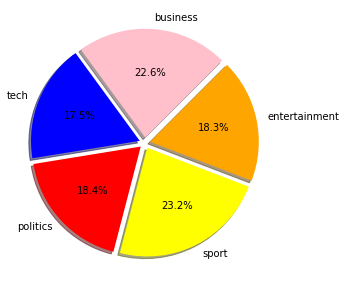

In [9]:
fig = plt.figure(figsize = (5,5))
colors = ['pink', 'blue', 'red', 'yellow', 'orange']
count = [dataset[dataset['CategoryId'] == i]['CategoryId'].count()
            for i in range(0, 5)]
pie = plt.pie(count, labels = ['business', 'tech', 'politics', 'sport', 'entertainment'],
    autopct = "%1.1f%%", shadow = True, colors = colors, startangle = 45,
    explode = (0.05, 0.05, 0.05, 0.05, 0.05))

The next thing to do is make a wordcloud of words in each category. This will aid us in seeing what the most commonly associated terms are with each field.

business related words:


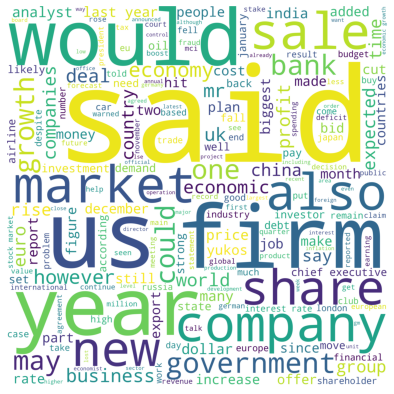

tech related words:


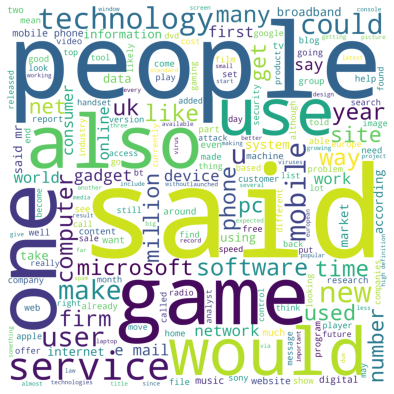

politics related words:


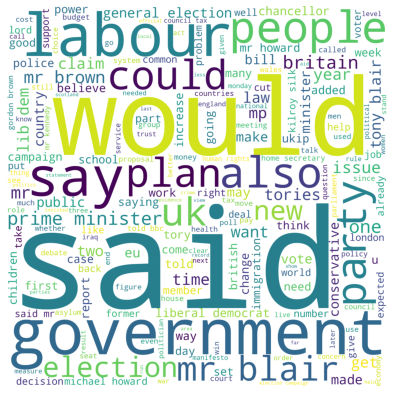

sport related words:


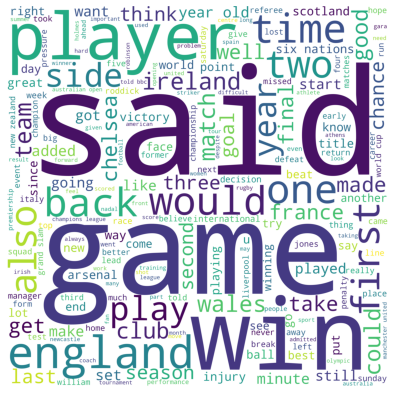

entertainment related words:


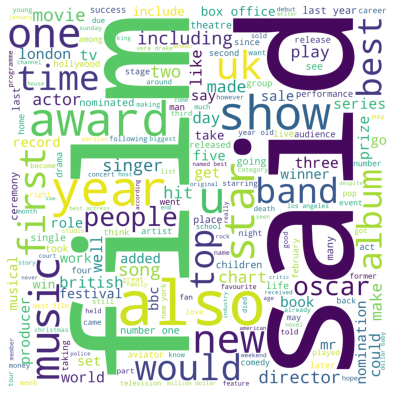

In [10]:
stop = set(stopwords.words('english'))

def wordcloud_draw(dataset, color = 'white'):
    words = ' '.join(dataset)
    cleaned_word = ' '.join([word for word in words.split()
        if (word != 'news' and word != 'text')])
    wordcloud = WordCloud(stopwords = stop,
        background_color = color,
        width = 2500, height = 2500).generate(cleaned_word)
    plt.figure(1, figsize = (10,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

items = ['business', 'tech', 'politics', 'sport', 'entertainment']

for i in range(0, 5):
    print(f'{items[i]} related words:')
    wordcloud_draw(dataset[dataset['CategoryId'] == i]['Text'])

Now we'll preview the columns of the dataset

In [11]:
# text column
text = dataset['Text']
text.head(10)

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
5    howard  truanted to play snooker  conservative...
6    wales silent on grand slam talk rhys williams ...
7    french honour for director parker british film...
8    car giant hit by mercedes slump a slump in pro...
9    fockers fuel festive film chart comedy meet th...
Name: Text, dtype: object

In [12]:
# category column
category = dataset['Category']
category.head(10)

0         business
1         business
2         business
3             tech
4         business
5         politics
6            sport
7    entertainment
8         business
9    entertainment
Name: Category, dtype: object

## Data Normalization

What we need to do next is clean up the data. We'll do this by removing tags, special characters, and stopwords. We'll also make everything lowercase. The purpose of this is to allow us to make more accurate models. Here, we remove the tags currently present in the dataset.

In [13]:
def remove_tags(text):
    remove = re.compile(r'')
    return re.sub(remove, '', text)

dataset['Text'] = dataset['Text'].apply(remove_tags)

Next we remove the special characters.

In [14]:
def special_char(text):
    reviews = ''
    for x in text:
        if x.isalnum():
            reviews = reviews + x
        else:
            reviews = reviews + ' '
    return reviews

dataset['Text'] = dataset['Text'].apply(special_char)

Then convert all articles to fully lower case.

In [15]:
def convert_lower(text):
    return text.lower()

dataset['Text'] = dataset['Text'].apply(convert_lower)

Finally, remove the stopwords.

In [16]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]

dataset['Text'] = dataset['Text'].apply(remove_stopwords)

### Lemmatization

As mentioned in the import block, lemmatization groups all the different inflections of the same word in order to analyze them as one entity. This is essentially another step in normalization. Thanks to the library, this step is very simple.

In [17]:
def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return ' '.join([wordnet.lemmatize(word) for word in text])

dataset['Text'] = dataset['Text'].apply(lemmatize_word)

## Post-Data-Cleaning

In [18]:
dataset

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex bos launch defence lawyer defendin...,business,0
1,154,german business confidence slide german busine...,business,0
2,1101,bbc poll indicates economic gloom citizen majo...,business,0
3,1976,lifestyle governs mobile choice faster better ...,tech,1
4,917,enron boss 168m payout eighteen former enron d...,business,0
...,...,...,...,...
1485,857,double eviction big brother model caprice holb...,entertainment,4
1486,325,dj double act revamp chart show dj duo jk joel...,entertainment,4
1487,1590,weak dollar hit reuters revenue medium group r...,business,0
1488,1587,apple ipod family expands market apple expande...,tech,1


## Declare Dependent and Independent Values

We now will select variables to use as dependent and independent values.

In [19]:
x = dataset['Text']
y = dataset['CategoryId']

## Create and Fit a BoW Model

Basically this step will construct a vector within which each element will describe the frequency of a given word. If a word is frequent, the value is 1, otherwise it's 0.

This approach is applied because algorithms work faster with numbers, and the BoW model gives a numerical representation of the text, allowing our NLP model to work faster.

In [20]:
x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.CategoryId.values)
cv = CountVectorizer(max_features=5000)
x = cv.fit_transform(dataset.Text).toarray()
print(f'{x.shape=}\n{y.shape=}')

x.shape=(1490, 5000)
y.shape=(1490,)


Now, in order to properly generate a model, we need to split the data into training and testing sets of data. This will make it easier to test the model.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
print(f'size of training set: {len(x_train)}\nsize of testing set: {len(x_test)}')

size of training set: 1043
size of testing set: 447


## Create, Fit, and Predict all ML Models

Finally, we can create, fit, and predict all the models.

In [22]:
perform_list = []

def run_model(model_name):
    mdl = ''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest Classifier':
        mdl = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0, fit_prior=True)
    elif model_name == 'Support Vector Classifier':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbor':
        mdl = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()
    
    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)
    
    # performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    
    # get precision, recall, f1 scores
    scores = classification_report(y_test, y_pred, output_dict=True)['weighted avg']
    precision = scores['precision']
    recall = scores['recall']
    f1score = scores['f1-score']
    support = scores['support']
    
    print(f'Test Accuracy Score of Basic {model_name}: {accuracy}%')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score  : {f1score}')
    
    # add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
    ]))

### Models

In [23]:
models = ['Logistic Regression', 'Random Forest Classifier', 'Multinomial Naive Bayes', 'Support Vector Classifier', 'Decision Tree Classifier', 'K Nearest Neighbor', 'Gaussian Naive Bayes']

for model in models:
    print(f'{model}:')
    try:
        run_model(model)
    except:
        print('Model failed')
    print()

Logistic Regression:
Test Accuracy Score of Basic Logistic Regression: 97.09%
Precision : 0.9717641477893112
Recall    : 0.970917225950783
F1-score  : 0.9707131738531314

Random Forest Classifier:
Test Accuracy Score of Basic Random Forest Classifier: 97.99%
Precision : 0.9800622418655248
Recall    : 0.9798657718120806
F1-score  : 0.9797195174070333

Multinomial Naive Bayes:
Test Accuracy Score of Basic Multinomial Naive Bayes: 97.09%
Precision : 0.9713686408891803
Recall    : 0.970917225950783
F1-score  : 0.9708538373728814

Support Vector Classifier:
Test Accuracy Score of Basic Support Vector Classifier: 96.64%
Precision : 0.9673893060446985
Recall    : 0.9664429530201343
F1-score  : 0.9664172903928937

Decision Tree Classifier:
Test Accuracy Score of Basic Decision Tree Classifier: 82.1%
Precision : 0.873670046243466
Recall    : 0.8210290827740492
F1-score  : 0.8259399993449116

K Nearest Neighbor:
Test Accuracy Score of Basic K Nearest Neighbor: 73.6%
Precision : 0.794472553720390

### Best Model Performance

Now we'll find the model that performed the best. To do this, we'll first make a dataframe that contains all the information.

In [24]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance = model_performance.sort_values(by=['Test Accuracy'], ascending=False).reset_index(drop=True)
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest Classifier,97.99,0.98,0.98,0.98
1,Logistic Regression,97.09,0.97,0.97,0.97
2,Multinomial Naive Bayes,97.09,0.97,0.97,0.97
3,Support Vector Classifier,96.64,0.97,0.97,0.97
4,Decision Tree Classifier,82.10,0.87,0.82,0.83
5,Gaussian Naive Bayes,76.06,0.87,0.76,0.78
6,K Nearest Neighbor,73.60,0.79,0.74,0.74


In [25]:
model = model_performance['Model'][0]
max_acc = model_performance['Test Accuracy'][0]
print(f'The accuracy of the {model} is {max_acc}%!')

The accuracy of the Random Forest Classifier is 97.99%!
